# Уменьшение потребления электроэнергии в ООО "Так закаляем сталь"

**Цель проекта:** Оптимизировать производственные расходы металлургического комбината ООО «Так закаляем сталь» за счёт уменьшения потребления электроэнергии на этапе обработки стали. Уменьшить потребление электроэнергии необходимо за счёт предсказания температуры стали после обработки в ковше.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## План работы

1. Загружаем данные и ознакамливаемся с данными
2. Проводим исследовательский анализ
3. Выполним предобработку данных: приведём к нужным типам, удалим лишнее и т.п.
4. Выберем регрессионные модели, которые будем использовать. Скорее всего это будут: LinearRegression, CatBoost, LightGBM, Lasso
5. Выберем и соединим все нужные данные в одну таблицу по партиям
6. Подготовим данные для моделей: удалим / заполним пропуски, разделим на выборки
7. Обучим выбранные модели с подбором параметров на валидационной выборке
8. Обучим модели с лучшими параметрами на выборке трейн+валид и рассчитаем метрику на тесте
9. Сравним результаты моделей и напишем отчет

**Целевая метрика:** MAE < 6

## Загрузка данных

In [1]:
import math
import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression, Lasso
from catboost import CatBoostRegressor, Pool, cv
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Анализ данных об электродах

In [3]:
def data_an(data):
    display(data.head())
    display(data.describe().round(3))
    print('Количество дубликатов:', data.duplicated().sum())
    print()
    data.info()

In [4]:
desc = data_arc.describe()
desc.loc['count'] = desc.loc['count'].astype('int')

In [5]:
data_an(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Активная мощность,Реактивная мощность
count,14876.000,14876.000,14876.000
mean,1615.220,0.670,0.453
std,934.572,0.408,5.879
min,1.000,0.030,-715.505
25%,806.000,0.395,0.291
50%,1617.000,0.556,0.416
75%,2429.000,0.857,0.637
max,3241.000,3.732,2.676


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Сделаем корректный тип данных для дат.

In [6]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_an(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Активная мощность,Реактивная мощность
count,14876.000,14876.000,14876.000
mean,1615.220,0.670,0.453
std,934.572,0.408,5.879
min,1.000,0.030,-715.505
25%,806.000,0.395,0.291
50%,1617.000,0.556,0.416
75%,2429.000,0.857,0.637
max,3241.000,3.732,2.676


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [7]:
def draw_plots(data, column):
    
    boxplot = plt.boxplot(data[column])
    whiskers_list = [item.get_ydata() for item in boxplot['whiskers']]
    lower_whisker = whiskers_list[0][1]
    upper_whisker = whiskers_list[1][1]
    outliers = list(boxplot['fliers'][0].get_data()[1])
    plt.close()
    
    plt.figure(figsize=(12, 6), dpi= 80)
    ax = sns.distplot(data[column], bins=40, color='c')
    if np.isnan(lower_whisker)==False or np.isnan(upper_whisker)==False:
        xlim = ax.get_xlim()
        plt.axvspan(xlim[0], lower_whisker, color='r', alpha=.3, label='Стат выбросы')
        plt.axvspan(upper_whisker, xlim[1], color='r', alpha=.3)
    plt.axvline(np.mean(data[column]),color='g', linestyle='--', label='Среднее', linewidth=2)
    plt.axvline(np.median(data[column]),color='g', linestyle='-', label='Медиана', linewidth=2)
    plt.legend()
    plt.title(f'Распределние {column}')
    plt.xlabel(column)
    plt.ylabel('Плотность вероятности')
    plt.show()
    
    print('Количество статистических выбросов =',len(outliers))
    print('Доля статистических выбросов =',round(len(outliers)/data[column].count(),4))

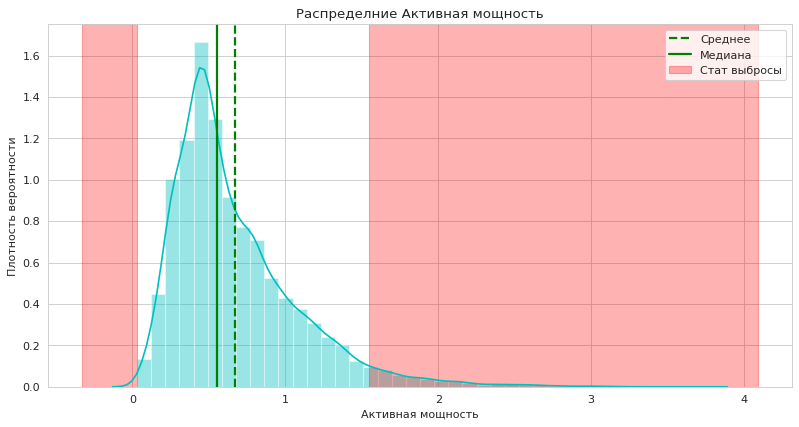

Количество статистических выбросов = 569
Доля статистических выбросов = 0.0382


In [8]:
draw_plots(data_arc, 'Активная мощность')

Данные по активной мощности выглядят нормально. Есть небольшое кол-во статистических выбросов, которые находятся за пределами 1.5 межквартильных размахов, но не факт, что эти значения невозможны при производстве.

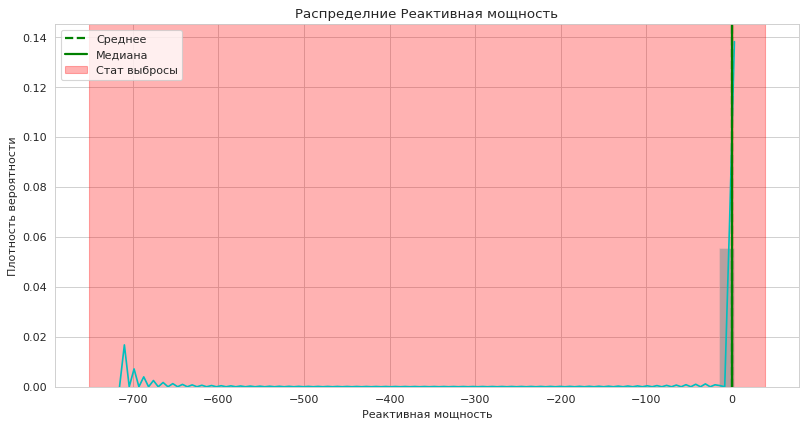

Количество статистических выбросов = 601
Доля статистических выбросов = 0.0404


In [9]:
draw_plots(data_arc, 'Реактивная мощность')

In [10]:
display(data_arc.sort_values('Реактивная мощность').head(10))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
5596,1216,2019-06-16 08:22:19,2019-06-16 08:22:30,0.030188,0.020806
2419,521,2019-05-22 17:42:57,2019-05-22 17:43:11,0.030563,0.021154
4914,1060,2019-06-11 04:31:57,2019-06-11 04:32:08,0.031630,0.022485
4633,1000,2019-06-09 01:17:44,2019-06-09 01:17:57,0.038186,0.022983
676,146,2019-05-08 19:18:55,2019-05-08 19:19:07,0.035400,0.023228
4063,873,2019-06-04 18:34:19,2019-06-04 18:34:30,0.040905,0.023569
6580,1432,2019-06-23 21:13:19,2019-06-23 21:13:34,0.034053,0.025329
8704,1892,2019-07-09 18:51:37,2019-07-09 18:51:50,0.038364,0.026079
4615,996,2019-06-08 22:06:27,2019-06-08 22:09:03,0.035165,0.026222


Реактивная мощность = -715 выглядит мощнейшим выбросом относительно других значений. Избавлюсь от него.

In [11]:
data_arc = data_arc[data_arc['Реактивная мощность'] >= 0]

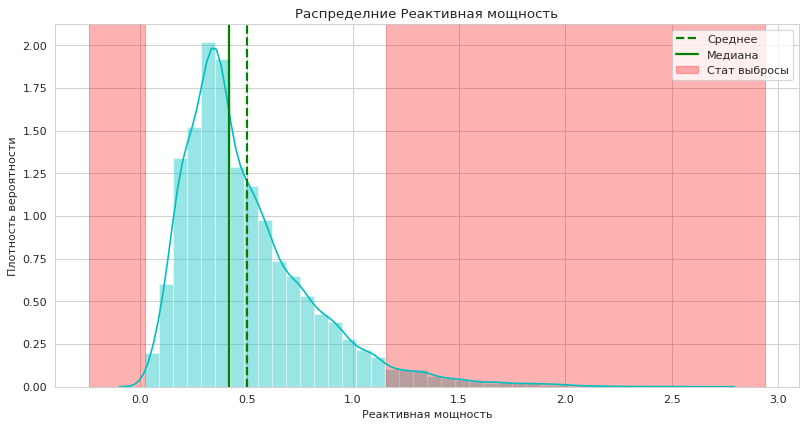

Количество статистических выбросов = 599
Доля статистических выбросов = 0.0403


In [12]:
draw_plots(data_arc, 'Реактивная мощность')

Так данные выглядят намного лучше.

### Анализ данных о подаче сыпучих материалов (объём)

In [13]:
data_an(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000,252.000,22.000,1298.000,1014.000,77.000,576.000,25.000,1.0,19.000,176.000,177.000,2450.000,18.000,2806.000,2248.000
mean,1624.384,39.242,253.045,113.879,104.394,107.026,118.925,305.600,49.0,76.316,83.284,76.819,260.471,181.111,170.285,160.513
std,933.338,18.278,21.181,75.483,48.184,81.791,72.058,191.023,NaN,21.721,26.060,59.655,120.649,46.088,65.869,51.765
min,1.000,10.000,228.000,6.000,12.000,11.000,17.000,47.000,49.0,63.000,24.000,8.000,53.000,151.000,16.000,1.000
25%,816.000,27.000,242.000,58.000,72.000,70.000,69.750,155.000,49.0,66.000,64.000,25.000,204.000,153.250,119.000,105.000
50%,1622.000,31.000,251.500,97.500,102.000,86.000,100.000,298.000,49.0,68.000,86.500,64.000,208.000,155.500,151.000,160.000
75%,2431.000,46.000,257.750,152.000,133.000,132.000,157.000,406.000,49.0,70.500,102.000,106.000,316.000,203.500,205.750,205.000
max,3241.000,185.000,325.000,454.000,281.000,603.000,503.000,772.000,49.0,147.000,159.000,313.000,1849.000,305.000,636.000,405.000


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Пустые значения в сыпучих материалах объясняются просто - для каждой партии подбирают определённое сочетание сыпучих материалов. Преположительно весь объём по каждой партии нужно будет суммировать.

В этом датасете есть не все партии - кол-во key = 3129, а максимальный key = 3241. Возможно не во все партии добавляли вещества.

### Анализ данных о подаче сыпучих материалов время

In [14]:
data_an(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key
count,3129.000
mean,1624.384
std,933.338
min,1.000
25%,816.000
50%,1622.000
75%,2431.000
max,3241.000


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Этот датасет сообщает нам в какое время были добавлены сыпучие вещества из датасета с объёмом сыпучих веществ. Не знаю насколько полезен этот датасет для нас, т.к. объём мы собираемся суммировать.

### Анализ данных о продувке сплава газом

In [15]:
data_an(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000,3239.000
mean,1621.861,11.002
std,935.386,6.220
min,1.000,0.008
25%,812.500,7.043
50%,1622.000,9.836
75%,2431.500,13.770
max,3241.000,77.995


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Судя по всему не хватает 2 партий - максимум = 3241, а количество = 3239

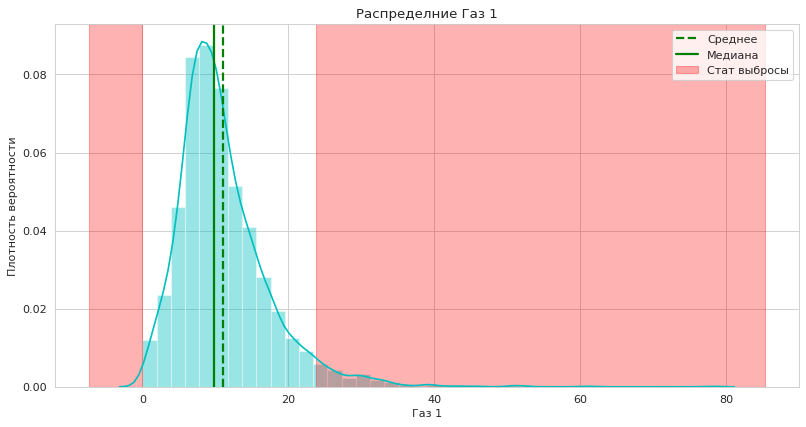

Количество статистических выбросов = 126
Доля статистических выбросов = 0.0389


In [16]:
draw_plots(data_gas, 'Газ 1')

In [17]:
display(data_gas.sort_values(by='Газ 1', ascending=False).head(10))

,key,Газ 1
319,322,77.995040
277,280,60.935689
2107,2110,52.142373
2567,2570,51.380229
116,117,50.581035
2105,2108,45.638999
1461,1464,43.655411
660,663,41.854643
525,528,39.728826
610,613,39.425706


Данные выглядят в порядке, ничего критичного не вижу.

### Анализ результатов измерения температуры

In [18]:
data_an(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Температура
count,15907.000,13006.000
mean,1607.881,1591.841
std,942.212,21.376
min,1.000,1191.000
25%,790.000,1581.000
50%,1618.000,1591.000
75%,2427.000,1601.000
max,3241.000,1705.000


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Судя по всему температура не везде записалась, т.к. есть пропуски, а жаль. Скорее всего придётся дропать пустые строки.

Средняя температура практически равна медианной.

Изменим тип данных у времени замера.

In [19]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


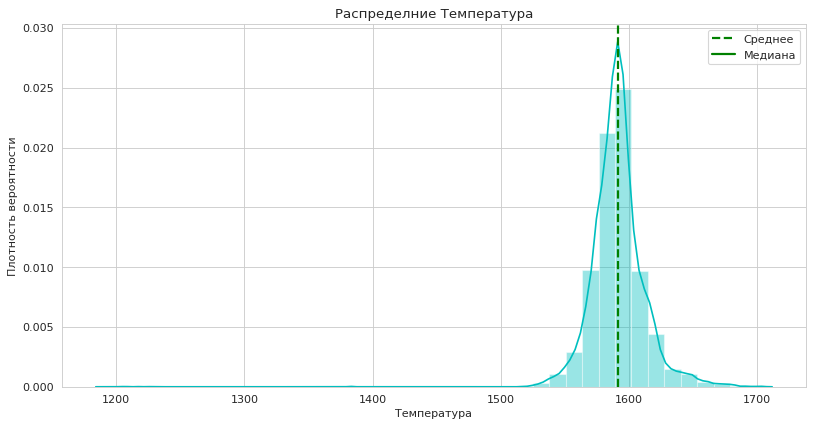

Количество статистических выбросов = 0
Доля статистических выбросов = 0.0


In [20]:
draw_plots(data_temp, 'Температура')

In [21]:
temp = data_temp.groupby('key', as_index=False)['Температура'].count()
temp_count = temp.groupby('Температура', as_index=False).count()
temp_count.rename(columns={'key':'Кол-во партий', 'Температура':'Кол-во замеров'}, inplace=True)
display(temp_count)

,Кол-во замеров,Кол-во партий
0,1,741
1,2,56
2,3,432
3,4,650
4,5,585
5,6,370
6,7,182
7,8,100
8,9,43
9,10,21


По 741 партии был сделан всего 1 замер. Т.к. для модели таргетом будет являться конечная температура, скорее всего все партии с одним замером придётся удалить, т.к. будет сложно выяснить какой по счёту замер температуры мы видим - первый, последний или какой-то промежуточный.

### Анализ данных о проволочных материалах + время

In [22]:
data_an(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000,3055.000,1079.000,63.000,14.000,1.000,73.000,11.000,19.000,29.000
mean,1623.426,100.896,50.577,189.483,57.443,15.132,48.017,10.039,53.625,34.156
std,932.997,42.013,39.320,99.513,28.825,NaN,33.920,8.611,16.882,19.932
min,1.000,1.919,0.030,0.144,24.149,15.132,0.034,0.234,45.077,4.623
25%,823.000,72.116,20.194,95.135,40.807,15.132,25.054,6.763,46.095,22.058
50%,1619.000,100.158,40.143,235.195,45.234,15.132,42.076,9.017,46.280,30.066
75%,2434.000,126.060,70.228,276.252,76.125,15.132,64.213,11.886,48.090,43.862
max,3241.000,330.314,282.780,385.009,113.231,15.132,180.455,32.848,102.762,90.054


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [23]:
data_an(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000
mean,1623.426
std,932.997
min,1.000
25%,823.000
50%,1619.000
75%,2434.000
max,3241.000


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


По этим двум датасетам ситуация аналогична сыпучим материалам. Скорее всего объём проволок будем скалыдвать, а время нам не понадобится.

## Подготовка признаков

За основу возьмём таблицу с температурами, т.к. в ней у нас таргет, а далее к ней будет присоединять остальные признаки.

### Измерения температуры

In [24]:
display(data_temp.head())

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [25]:
data_temp = data_temp.dropna().reset_index(drop=True)

In [26]:
df = data_temp.groupby(by='key').agg(measure_count=('Температура', 'count'),
                                                  first_temp_dttm=('Время замера', 'first'),
                                                  first_temp=('Температура', 'first'),
                                                  last_temp_dttm=('Время замера', 'last'),
                                                  last_temp=('Температура', 'last')
                                                 ).reset_index()
display(df.head())

,key,measure_count,first_temp_dttm,first_temp,last_temp_dttm,last_temp
0,1,5,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,6,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,5,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,3,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0


In [27]:
display(df[df['measure_count']<=1].head())
display(df[df['measure_count']<=1]['key'].count())

,key,measure_count,first_temp_dttm,first_temp,last_temp_dttm,last_temp
192,195,1,2019-05-10 14:10:23,1583.0,2019-05-10 14:10:23,1583.0
276,279,1,2019-05-13 23:07:28,1603.0,2019-05-13 23:07:28,1603.0
2477,2500,1,2019-08-06 03:11:31,1539.0,2019-08-06 03:11:31,1539.0
2478,2501,1,2019-08-06 03:44:42,1587.0,2019-08-06 03:44:42,1587.0
2479,2502,1,2019-08-06 04:45:26,1583.0,2019-08-06 04:45:26,1583.0


741

Удалим партии с замерами температуры <=1, т.к. сложно определить какой по счёту это замер. В таргете нужен только последний.

In [28]:
df = df[df['measure_count']>1]

С температурой закончили. Перейдём к нагреваниям электродами.

### Электроды

In [29]:
display(data_arc.head())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Эти данные нужно агрегировать - вытащить суммарные мощности, первое и последнее нагревания, чтобы сравнить его с временем замера температур.

In [30]:
display(data_arc.head())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [31]:
df_arc = data_arc.groupby(by='key').agg(first_heat_dttm=('Начало нагрева дугой', 'first'),
                                                    last_heat_dttm=('Конец нагрева дугой', 'last'),
                                                    sum_active_power=('Активная мощность', 'sum'),
                                                    sum_reactive_power=('Реактивная мощность', 'sum')
                                                    #heat_count=('Начало нагрева дугой', 'count') маловажный признак
                                                    ).reset_index()
display(df_arc.head())

,key,first_heat_dttm,last_heat_dttm,sum_active_power,sum_reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,4.878147,3.183241
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,3.052598,1.998112
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,2.525882,1.599076
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,3.209250,2.060298
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,3.347173,2.252643


In [32]:
df_fin = df.merge(df_arc, on='key', how='left')
display(df_fin.head())

,key,measure_count,first_temp_dttm,first_temp,last_temp_dttm,last_temp,first_heat_dttm,last_heat_dttm,sum_active_power,sum_reactive_power
0,1,5,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,4.878147,3.183241
1,2,6,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,3.052598,1.998112
2,3,5,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,2.525882,1.599076
3,4,3,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,3.209250,2.060298
4,5,2,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,3.347173,2.252643


In [33]:
display(df_fin.query('last_temp_dttm < last_heat_dttm | first_temp_dttm > first_heat_dttm').head())

,key,measure_count,first_temp_dttm,first_temp,last_temp_dttm,last_temp,first_heat_dttm,last_heat_dttm,sum_active_power,sum_reactive_power
0,1,5,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,4.878147,3.183241
1,2,6,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,3.052598,1.998112
2,3,5,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,2.525882,1.599076
3,4,3,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,3.209250,2.060298
4,5,2,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,3.347173,2.252643


In [34]:
print('Кол-во партий с нагревом до первого замера температуры',
      df_fin.query('first_temp_dttm > first_heat_dttm')['key'].count())
print('Доля партий с нагревом до первого замера температуры',
      round(df_fin.query('first_temp_dttm > first_heat_dttm')['key'].count()/df_fin['key'].count(), 4))

Кол-во партий с нагревом до первого замера температуры 2442
Доля партий с нагревом до первого замера температуры 0.9867


Надо уточнять у бизнеса зачем нагревают до первого замера температуры.

In [35]:
print('Кол-во партий с нагревом после последнего замера температуры',
      df_fin.query('last_temp_dttm < last_heat_dttm')['key'].count())
print('Доля партий с нагревом после последнего замера температуры',
      round(df_fin.query('last_temp_dttm < last_heat_dttm')['key'].count()/df_fin['key'].count(), 4))

Кол-во партий с нагревом после последнего замера температуры 131
Доля партий с нагревом после последнего замера температуры 0.0529


Партии, которые нагревались после финального замера температуры, будем удалять. Т.к. последний замер температуры - это таргет, после которого не должно выполняться каких-либо действий.

In [36]:
df_fin = df_fin.query('last_temp_dttm >= last_heat_dttm')

Переходим к сыпучим материалам. Посчитаем количество засыпаний.

### Сыпучие материалы

In [37]:
#data_bulk['bulk_count'] = data_bulk.iloc[:,1:].count(axis=1) маловажный признак
df_bulk = data_bulk.fillna(0)
display(df_bulk.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Просуммируем все засыпанные объёмы.

In [38]:
df_bulk['bulk_sum'] = df_bulk.iloc[:,1:16].sum(axis=1)
#df_bulk = df_bulk[['key', 'bulk_sum', 'bulk_count']] оставим все зассыпанные присадки
display(df_bulk.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


In [39]:
display(data_bulk_time.head())
data_bulk_time.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Из времени засыпания материалов нужно достать первое и последнее время, чтобы сравнить с временем замеров температур.

In [40]:
data_bulk_time.iloc[:,1:] = data_bulk_time.iloc[:,1:].apply(pd.to_datetime)
data_bulk_time['min_bulk_dttm'] = data_bulk_time.iloc[:,1:].min(axis=1)
data_bulk_time['max_bulk_dttm'] = data_bulk_time.iloc[:,1:].max(axis=1)
display(data_bulk_time.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,min_bulk_dttm,max_bulk_dttm
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:21:30
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:38
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:31:06
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:48:43
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:18:50


In [41]:
df_bulk = df_bulk.merge(data_bulk_time[['key', 'min_bulk_dttm', 'max_bulk_dttm']], on='key', how='left')
display(df_bulk.head())
df_bulk.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum,min_bulk_dttm,max_bulk_dttm
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,2019-05-03 11:03:52,2019-05-03 11:21:30
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,2019-05-03 11:40:20,2019-05-03 11:46:38
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,2019-05-03 12:09:40,2019-05-03 12:31:06
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,2019-05-03 12:41:24,2019-05-03 12:48:43
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,2019-05-03 13:12:56,2019-05-03 13:18:50


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 0 to 3128
Data columns (total 19 columns):
key              3129 non-null int64
Bulk 1           3129 non-null float64
Bulk 2           3129 non-null float64
Bulk 3           3129 non-null float64
Bulk 4           3129 non-null float64
Bulk 5           3129 non-null float64
Bulk 6           3129 non-null float64
Bulk 7           3129 non-null float64
Bulk 8           3129 non-null float64
Bulk 9           3129 non-null float64
Bulk 10          3129 non-null float64
Bulk 11          3129 non-null float64
Bulk 12          3129 non-null float64
Bulk 13          3129 non-null float64
Bulk 14          3129 non-null float64
Bulk 15          3129 non-null float64
bulk_sum         3129 non-null float64
min_bulk_dttm    3129 non-null datetime64[ns]
max_bulk_dttm    3129 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(16), int64(1)
memory usage: 488.9 KB


In [42]:
df_fin = df_fin.merge(df_bulk, on='key', how='left')
display(df_fin.head())

,key,measure_count,first_temp_dttm,first_temp,last_temp_dttm,last_temp,first_heat_dttm,last_heat_dttm,sum_active_power,sum_reactive_power,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum,min_bulk_dttm,max_bulk_dttm
0,1,5,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,4.878147,3.183241,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,2019-05-03 11:03:52,2019-05-03 11:21:30
1,2,6,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,3.052598,1.998112,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,2019-05-03 11:40:20,2019-05-03 11:46:38
2,3,5,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,2.525882,1.599076,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,2019-05-03 12:09:40,2019-05-03 12:31:06
3,4,3,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,3.209250,2.060298,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,2019-05-03 12:41:24,2019-05-03 12:48:43
4,5,2,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,3.347173,2.252643,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,2019-05-03 13:12:56,2019-05-03 13:18:50


In [43]:
print('Кол-во партий с добавлением сыпучих веществ до первого замера температуры',
      df_fin.query('first_temp_dttm > min_bulk_dttm')['key'].count())
print('Доля партий с добавлением сыпучих веществ до первого замера температуры',
      round(df_fin.query('first_temp_dttm > min_bulk_dttm')['key'].count()/df_fin['key'].count(), 4))

Кол-во партий с добавлением сыпучих веществ до первого замера температуры 398
Доля партий с добавлением сыпучих веществ до первого замера температуры 0.1698


Нужно задать бизнесу вопрос зачем добавлять сыпучие вещества до первого замера температуры.

In [44]:
print('Кол-во партий с добавлением сыпучих веществ после финального замера температуры',
      df_fin.query('last_temp_dttm < max_bulk_dttm')['key'].count())
print('Доля партий с добавлением сыпучих веществ после финального замера температуры',
      round(df_fin.query('last_temp_dttm < max_bulk_dttm')['key'].count()/df_fin['key'].count(), 4))

Кол-во партий с добавлением сыпучих веществ после финального замера температуры 4
Доля партий с добавлением сыпучих веществ после финального замера температуры 0.0017


Партии, в которых были добавления веществ после финального замера, мы удалим из датасета, т.к. финальный замер - это таргет, после которого не должно быть никаких действий.

In [45]:
#макс балк дата <= последнему замеру или пустая
df_fin = df_fin.query('last_temp_dttm >= max_bulk_dttm | max_bulk_dttm != max_bulk_dttm')

С сыпучими материалами закончили. Переходим к проволчным.

### Проволочные материалы

In [46]:
display(data_wire.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#data_wire['count_wire'] = data_wire.iloc[:,1:].count(axis=1) маловажный признак
df_wire = data_wire.fillna(0)
df_wire['sum_wire'] = df_wire.iloc[:,1:10].sum(axis=1)
#df_wire = df_wire[['key', 'sum_wire', 'count_wire']] оставим все проволочные материалы
display(df_wire.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [48]:
data_wire_time.iloc[:,1:] = data_wire_time.iloc[:,1:].apply(pd.to_datetime)
data_wire_time['min_wire_dttm'] = data_wire_time.iloc[:,1:].min(axis=1)
data_wire_time['max_wire_dttm'] = data_wire_time.iloc[:,1:].max(axis=1)
display(data_wire_time.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,min_wire_dttm,max_wire_dttm
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:11:41,2019-05-03 11:11:41
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:46:10,2019-05-03 11:46:10
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:13:47,2019-05-03 12:13:47
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:48:05,2019-05-03 12:48:05
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:18:15,2019-05-03 13:32:06


In [49]:
df_wire = df_wire.merge(data_wire_time[['key', 'min_wire_dttm', 'max_wire_dttm']], on='key', how='left')
display(df_wire.head())
df_wire.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,min_wire_dttm,max_wire_dttm
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,2019-05-03 11:11:41,2019-05-03 11:11:41
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,2019-05-03 11:46:10,2019-05-03 11:46:10
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,2019-05-03 12:13:47,2019-05-03 12:13:47
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,2019-05-03 12:48:05,2019-05-03 12:48:05
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,2019-05-03 13:18:15,2019-05-03 13:32:06


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 0 to 3080
Data columns (total 13 columns):
key              3081 non-null int64
Wire 1           3081 non-null float64
Wire 2           3081 non-null float64
Wire 3           3081 non-null float64
Wire 4           3081 non-null float64
Wire 5           3081 non-null float64
Wire 6           3081 non-null float64
Wire 7           3081 non-null float64
Wire 8           3081 non-null float64
Wire 9           3081 non-null float64
sum_wire         3081 non-null float64
min_wire_dttm    3081 non-null datetime64[ns]
max_wire_dttm    3081 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(10), int64(1)
memory usage: 337.0 KB


In [50]:
df_fin = df_fin.merge(df_wire, on='key', how='left')
display(df_fin.head())

,key,measure_count,first_temp_dttm,first_temp,last_temp_dttm,last_temp,first_heat_dttm,last_heat_dttm,sum_active_power,sum_reactive_power,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,min_wire_dttm,max_wire_dttm
0,1,5,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,4.878147,3.183241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,2019-05-03 11:11:41,2019-05-03 11:11:41
1,2,6,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,3.052598,1.998112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,2019-05-03 11:46:10,2019-05-03 11:46:10
2,3,5,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,2.525882,1.599076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,2019-05-03 12:13:47,2019-05-03 12:13:47
3,4,3,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,3.209250,2.060298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,2019-05-03 12:48:05,2019-05-03 12:48:05
4,5,2,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,3.347173,2.252643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,2019-05-03 13:18:15,2019-05-03 13:32:06


In [51]:
print('Кол-во партий с добавлением проволоки до первого замера температуры',
      df_fin.query('first_temp_dttm > min_wire_dttm')['key'].count())
print('Доля партий с добавлением проволоки до первого замера температуры',
      round(df_fin.query('first_temp_dttm > min_wire_dttm')['key'].count()/df_fin['key'].count(), 4))

Кол-во партий с добавлением проволоки до первого замера температуры 195
Доля партий с добавлением проволоки до первого замера температуры 0.0833


Спрашиваем у бизнеса зачем добавлять материалы до замера первоначальной температуры.

In [52]:
print('Кол-во партий с добавлением проволоки после финального замера температуры',
      df_fin.query('last_temp_dttm < max_wire_dttm')['key'].count())
print('Доля партий с добавлением проволоки после финального замера температуры',
      round(df_fin.query('last_temp_dttm < max_wire_dttm')['key'].count()/df_fin['key'].count(), 4))

Кол-во партий с добавлением проволоки после финального замера температуры 0
Доля партий с добавлением проволоки после финального замера температуры 0.0


ОК. Остался газ.

### Газ

In [53]:
data_gas.rename(columns={'Газ 1':'gas'}, inplace=True)
display(data_gas.head())

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [54]:
df_fin = df_fin.merge(data_gas, on='key', how='left')
display(df_fin.head())
df_fin.info()

,key,measure_count,first_temp_dttm,first_temp,last_temp_dttm,last_temp,first_heat_dttm,last_heat_dttm,sum_active_power,sum_reactive_power,...,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,min_wire_dttm,max_wire_dttm,gas
0,1,5,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,2019-05-03 11:02:14,2019-05-03 11:28:37,4.878147,3.183241,...,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,2019-05-03 11:11:41,2019-05-03 11:11:41,29.749986
1,2,6,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,2019-05-03 11:34:14,2019-05-03 11:53:18,3.052598,1.998112,...,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,2019-05-03 11:46:10,2019-05-03 11:46:10,12.555561
2,3,5,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,2019-05-03 12:06:54,2019-05-03 12:32:19,2.525882,1.599076,...,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,2019-05-03 12:13:47,2019-05-03 12:13:47,28.554793
3,4,3,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,2019-05-03 12:39:37,2019-05-03 12:57:50,3.209250,2.060298,...,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,2019-05-03 12:48:05,2019-05-03 12:48:05,18.841219
4,5,2,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2019-05-03 13:11:13,2019-05-03 13:33:55,3.347173,2.252643,...,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,2019-05-03 13:18:15,2019-05-03 13:32:06,5.413692


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 0 to 2339
Data columns (total 41 columns):
key                   2340 non-null int64
measure_count         2340 non-null int64
first_temp_dttm       2340 non-null datetime64[ns]
first_temp            2340 non-null float64
last_temp_dttm        2340 non-null datetime64[ns]
last_temp             2340 non-null float64
first_heat_dttm       2340 non-null datetime64[ns]
last_heat_dttm        2340 non-null datetime64[ns]
sum_active_power      2340 non-null float64
sum_reactive_power    2340 non-null float64
Bulk 1                2279 non-null float64
Bulk 2                2279 non-null float64
Bulk 3                2279 non-null float64
Bulk 4                2279 non-null float64
Bulk 5                2279 non-null float64
Bulk 6                2279 non-null float64
Bulk 7                2279 non-null float64
Bulk 8                2279 non-null float64
Bulk 9                2279 non-null float64
Bulk 10               2279 non-nu

Получился практически итоговый датасет, который можно разбивать на выборки и начинать обучать модели.
Осталось:
1. Удалить лишние столбцы - даты и номер партии
2. Заполнить пропуски в объемах проволочных и сыпучих материалов, газе. Пропуски заполним 0, т.к. предположим, что если данных нет, значит ничего не добавляли.
3. Проверить признаки на мультиколлинеарность.

In [55]:
drop_col = ['key', 'measure_count',
            'first_temp_dttm', 'last_temp_dttm',
            'first_heat_dttm', 'last_heat_dttm',
            'min_bulk_dttm', 'max_bulk_dttm',
            'min_wire_dttm', 'max_wire_dttm']
final_df = df_fin.drop(drop_col, axis=1)
final_df.fillna(0, inplace=True)

data_an(final_df)

,first_temp,last_temp,sum_active_power,sum_reactive_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,gas
0,1571.0,1613.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986
1,1581.0,1602.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561
2,1596.0,1599.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793
3,1601.0,1625.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,18.841219
4,1576.0,1602.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,5.413692


,first_temp,last_temp,sum_active_power,sum_reactive_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,gas
count,2340.000,2340.000,2340.000,2340.000,2340.000,2340.000,2340.000,2340.000,2340.000,2340.000,...,2340.000,2340.000,2340.000,2340.0,2340.000,2340.000,2340.000,2340.000,2340.000,2340.000
mean,1588.376,1595.344,3.129,2.328,3.223,1.416,45.804,34.528,2.628,21.991,...,17.259,3.220,0.305,0.0,0.974,0.006,0.310,0.392,119.962,11.181
std,29.304,15.782,1.428,1.080,12.026,19.037,74.905,57.297,22.350,55.148,...,33.428,27.878,4.747,0.0,8.673,0.205,4.392,4.258,67.475,6.340
min,1191.000,1541.000,0.186,0.158,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000
25%,1572.000,1587.000,2.147,1.599,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,82.318,7.124
50%,1587.500,1593.000,3.024,2.229,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,114.048,9.956
75%,1605.000,1599.000,3.910,2.905,0.000,0.000,74.250,69.000,0.000,0.000,...,21.149,0.000,0.000,0.0,0.000,0.000,0.000,0.000,149.479,13.951
max,1679.000,1700.000,17.496,12.588,185.000,325.000,454.000,281.000,603.000,503.000,...,282.780,385.009,113.231,0.0,180.455,8.490,102.762,90.054,568.778,77.995


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 0 to 2339
Data columns (total 31 columns):
first_temp            2340 non-null float64
last_temp             2340 non-null float64
sum_active_power      2340 non-null float64
sum_reactive_power    2340 non-null float64
Bulk 1                2340 non-null float64
Bulk 2                2340 non-null float64
Bulk 3                2340 non-null float64
Bulk 4                2340 non-null float64
Bulk 5                2340 non-null float64
Bulk 6                2340 non-null float64
Bulk 7                2340 non-null float64
Bulk 8                2340 non-null float64
Bulk 9                2340 non-null float64
Bulk 10               2340 non-null float64
Bulk 11               2340 non-null float64
Bulk 12               2340 non-null float64
Bulk 13               2340 non-null float64
Bulk 14               2340 non-null float64
Bulk 15               2340 non-null float64
bulk_sum              2340 non-

In [56]:
target = final_df['last_temp']
features = final_df.drop('last_temp', axis=1)
display(features.shape, target.shape)

(2340, 30)

(2340,)

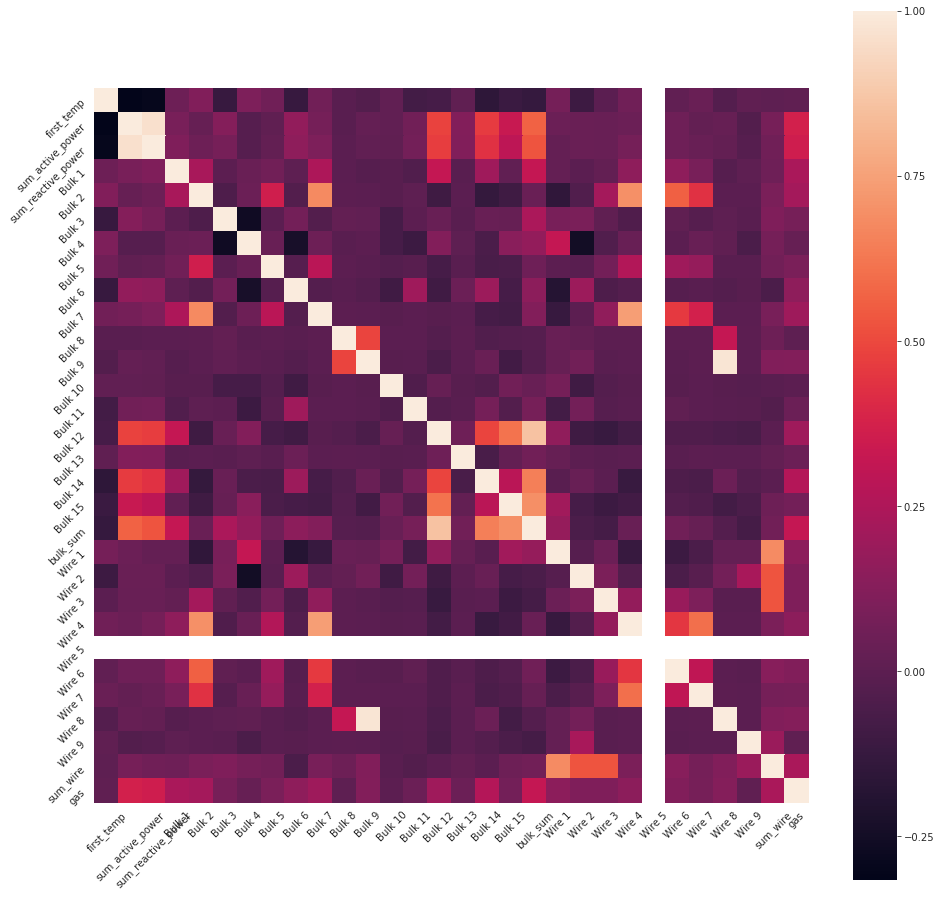

In [57]:
plt.figure(figsize=(16,16))
ax = sns.heatmap(features.corr(), square=True)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10, rotation=45)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10, rotation=45)
plt.show()

In [58]:
display(features['Wire 5'].value_counts())

0.0    2340
Name: Wire 5, dtype: int64

Мы видим, что у активной и реактивной мощностях корреляция очень высокая. Исключим один из признаков. Попробуем реактивную мощность.

Также признак Wire 5 явно бесползеный, т.к. в нём только значения = 0. Дропнем его.

In [59]:
features = features.drop(['sum_reactive_power', 'Wire 5'], axis=1)

### Вывод

Мы собрали датасет с признаками, который можно разбивать на выборки и обучать модели.

В процессе подготовки признаков возникли вопросы к бизнесу - зачем выполнять действия с партией (добавление материалов, нагрев) до первого и после финального замеров температуры?

Мы удалили из итогового датасета партии, по которым выполнялись действия после финального замера температуры, и с менее чем двумя замерами температуры.

Пропуски в данных по добавлением материалов и газа заполнили 0, т.к. предположили, если данных нет, значит добавлений не было.

Заметили коллинеарность в активной и реактивной мощностях, в связи с чем удалили один из признаков - реактивную мощность. Также удалили столбец Wire 5, т.к. в нём были только нули.

## Обучение моделей

Разобьём данные на выборки.

In [60]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25,
                                                                           random_state=12345)
display(features_train.shape, features_test.shape)

(1755, 28)

(585, 28)

Данные готовы к обучению.

Напишем функцию для отслеживания важности признаков.

In [61]:
def features_importance_plt(importance,features,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(features)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    ax = sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette='hls')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)
    plt.title('Важность признаков в ' + model_type, fontsize=16)
    plt.xlabel('Важность признака', fontsize=10.5)
    plt.ylabel('Название признака', fontsize=10.5)

### LinearRegression

In [62]:
X_train, features_valid, y_train, target_valid = train_test_split(features_train, target_train,
                                                                              test_size=.25, random_state=12345)
display(X_train.shape,features_valid.shape)

(1316, 28)

(439, 28)

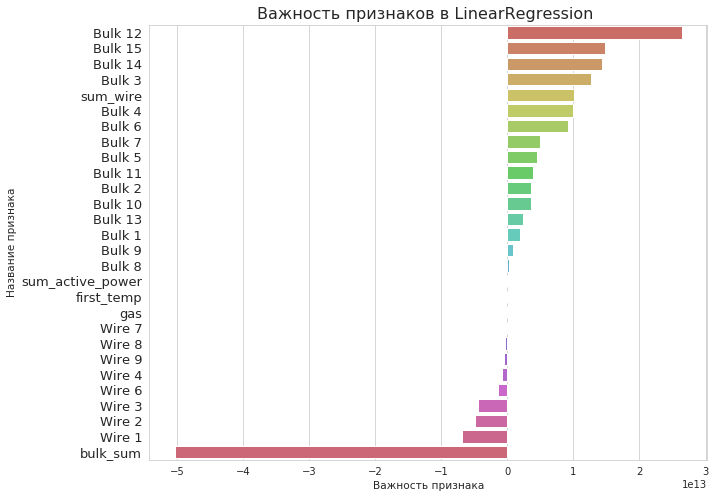

In [63]:
results = []

#scalers = [StandardScaler(), MinMaxScaler()]
s = StandardScaler()
s.fit(X_train)

X_train_scaled = s.transform(X_train)
features_valid_scaled = s.transform(features_valid)

model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
pred = model_lr.predict(features_valid_scaled)
results.append({'Модель': 'LinearRegression',
                'MAE': mae(target_valid, pred)})

features_importance_plt(model_lr.coef_, features.columns, 'LinearRegression ')

bulk_sum явно не самый важный признак для регрессии :)

Посмотрим что будет дальше.

In [64]:
display(results)

[{'Модель': 'LinearRegression', 'MAE': 8.714699280616532}]

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>ОК! важность для линейной регрессии смотрим по коэффициентам. Важно только помнить, что признаки обязательно всегда надо стандартизироыать для этого рейтина в линейной регрессии.

### Lasso

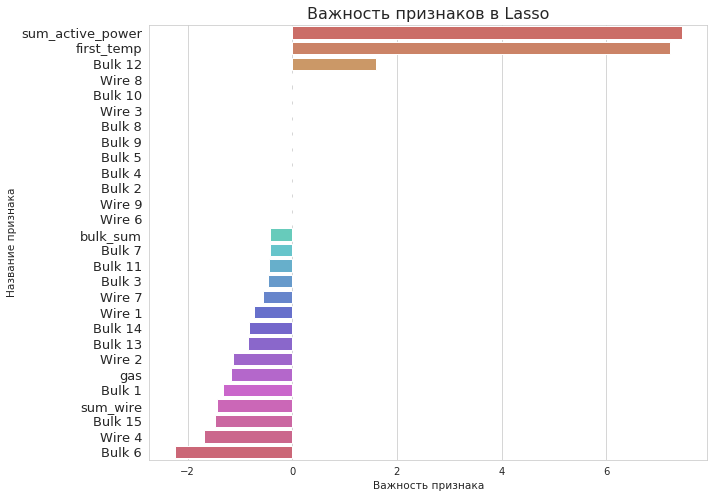

In [65]:
s.fit(features_train)

features_train_scaled = s.transform(features_train)

lasso_params = {'alpha':np.array([x for x in range(0,10001,250)])/10**4,
                'max_iter':range(500,1501,500),
                'random_state':[12345]}
model_lss = Lasso()

grid = GridSearchCV(model_lss,
                    param_grid=lasso_params,
                    scoring='neg_mean_absolute_error',
                    cv=5,
                    n_jobs=-1
                   ).fit(features_train_scaled, target_train)
model_lss.set_params(**grid.best_params_).fit(features_train_scaled, target_train)
pred_lss = model_lss.predict(features_train_scaled)
results.append({'Модель': 'Lasso',
                'MAE': mae(target_train, pred_lss)})
features_importance_plt(model_lss.coef_, features.columns, 'Lasso')

In [66]:
display(results)

[{'Модель': 'LinearRegression', 'MAE': 8.714699280616532},
 {'Модель': 'Lasso', 'MAE': 7.549048306563667}]

### CatBoost

In [67]:
cbr_pool_train = Pool(features_train, label=target_train)
cbr_pool_v = Pool(features_train)

cbr_params = {#'iterations':range(386,395),
              #'depth':[3,4],
              'learning_rate':np.array([x for x in range(15490,15510)])/10**5
              #'l2_leaf_reg':[2,3,4,5,7]
             }

model_cbr = CatBoostRegressor(loss_function='MAE', #'RMSE'
                              #eval_metric='MAE',
                              iterations=386,
                              depth=3,
                              l2_leaf_reg=3,
                              #learning_rate=0.155,
                              grow_policy='SymmetricTree',
                              random_state=12345,
                              logging_level='Silent')

#сделаю заметкой, очень долго работающая штука. время работы на серверах яндекса ~4 часа, локально ~1.5 часа


grid_search_result = model_cbr.grid_search(cbr_params, cv=5, X=cbr_pool, verbose=5) #X=features_train, y=target_train)#, plot=True)

Лучшие параметры после gridsearch:
{'iterations': 386,
 'depth': 3,
 'l2_leaf_reg': 3,
 'loss_function': 'MAE',
 'logging_level': 'Silent',
 'random_state': 12345,
 'grow_policy': 'SymmetricTree',
 'learning_rate': 0.155}

In [68]:
#cbr_best_params = model_cbr.get_params()
cbr_best_params = {'iterations': 386,
 'depth': 3,
 'l2_leaf_reg': 3,
 'loss_function': 'MAE',
 'logging_level': 'Silent',
 'random_state': 12345,
 'grow_policy': 'SymmetricTree',
 'learning_rate': 0.155}
display('Лучшие параметры', cbr_best_params)

'Лучшие параметры'

{'iterations': 386,
 'depth': 3,
 'l2_leaf_reg': 3,
 'loss_function': 'MAE',
 'logging_level': 'Silent',
 'random_state': 12345,
 'grow_policy': 'SymmetricTree',
 'learning_rate': 0.155}

In [69]:
model_cbr = CatBoostRegressor(**cbr_best_params)
model_cbr.fit(cbr_pool_train)
pred_cbr = model_cbr.predict(cbr_pool_v)
MAE = mae(target_train, pred_cbr)
results.append({'Модель': 'CatBoostRegressor', 
                'Параметры': cbr_best_params,
                'MAE': MAE})

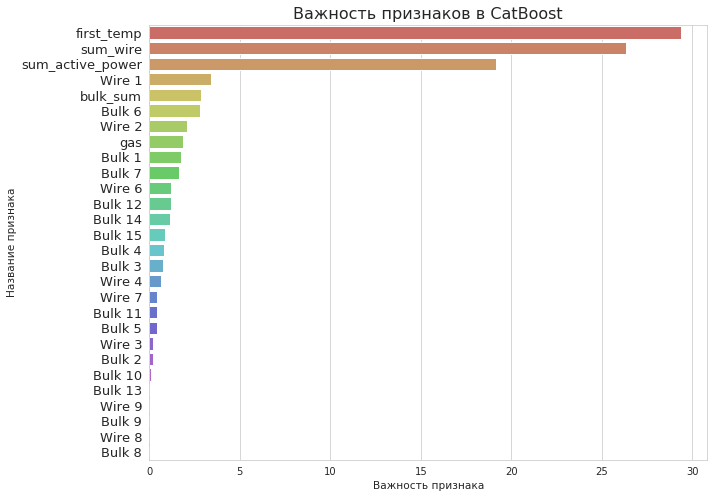

In [70]:
features_importance_plt(model_cbr.feature_importances_, features_train.columns, 'CatBoost')

<div class="alert alert-block alert-warning">
<b>Комментарий студента ПОСЛЕ РЕВЬЮ 2:</b> это новое.
</div>

Уберём маловажные признаки.

In [71]:
cbr_non_imp_feat = ['Bulk 13', 'Wire 9', 'Bulk 9', 'Wire 8', 'Bulk 8']
cbr_features_train = features_train.drop(cbr_non_imp_feat, axis=1)
cbr_features_test = features_test.drop(cbr_non_imp_feat, axis=1)

cbr_pool_train_fi = Pool(cbr_features_train, label=target_train)
cbr_pool_v_fi = Pool(cbr_features_train)

model_cbr.fit(cbr_pool_train_fi)
pred_cbr = model_cbr.predict(cbr_pool_v_fi)
MAE = mae(target_train, pred_cbr)
results.append({'Модель': 'CatBoostRegressor WO NI', 
                'Параметры': cbr_best_params,
                'MAE': MAE})

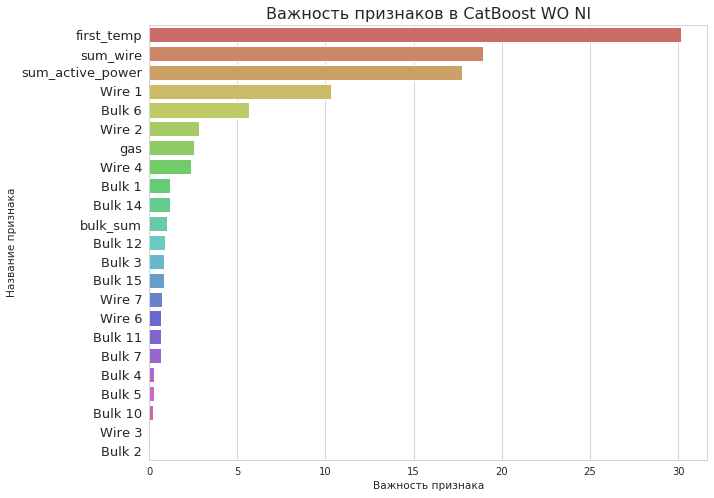

In [72]:
features_importance_plt(model_cbr.feature_importances_, cbr_features_train.columns, 'CatBoost WO NI')

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>писал, наверное, уже. Но повторюсь: хорошо, что используешь этот инструмент. На начальном этапе мы можем нагенерить множество разных фич, в том чтисле и лишних. И вот этот инструмент, вкупе с анализом мультиколлинеарности позволяет избавляться от "балласта")

### LGBMRegressor

#долго отрабатывает, делаю заметкой


lgbm_params = {
    #'num_leaves':range(7,12),
    #'max_depth':[3,4],
    #'learning_rate':np.array([x for x in range(798,803)])/10**4
    #'n_estimators':range(144,148)
    'lambda_l1':range(48,53),
    }
model_lgbm = lgb.LGBMRegressor(max_depth=3,
                               n_estimators=147,
                               num_leaves=8,
                               learning_rate=0.08,
                               lambda_l1=50
                               random_state=12345)

grid = GridSearchCV(model_lgbm,
                    param_grid=lgbm_params,
                    scoring='neg_mean_absolute_error',
                    cv=5).fit(features_train, target_train)

In [73]:
#lgbm_best_params = grid.best_params_
lgbm_best_params = {'max_depth':3,
                    'n_estimators':147,
                    'num_leaves':8,
                    'learning_rate':0.08,
                    'lambda_l1':50,
                    'random_state':12345}
display(lgbm_best_params)

{'max_depth': 3,
 'n_estimators': 147,
 'num_leaves': 8,
 'learning_rate': 0.08,
 'lambda_l1': 50,
 'random_state': 12345}

Лучшие параметры LGBM после GridSearch
{'max_depth': 3,
 'n_estimators': 147,
 'num_leaves': 8,
 'learning_rate': 0.08,
 'lambda_l1': 50,
 'random_state': 12345}

In [74]:
model_lgbm = lgb.LGBMRegressor(**lgbm_best_params)
model_lgbm.fit(features_train,target_train)
pred_lgbm = model_lgbm.predict(features_train)
results.append({'Модель': 'LGBMRegressor', 
                'Параметры': lgbm_best_params,  
                'MAE': mae(target_train, pred_lgbm)})

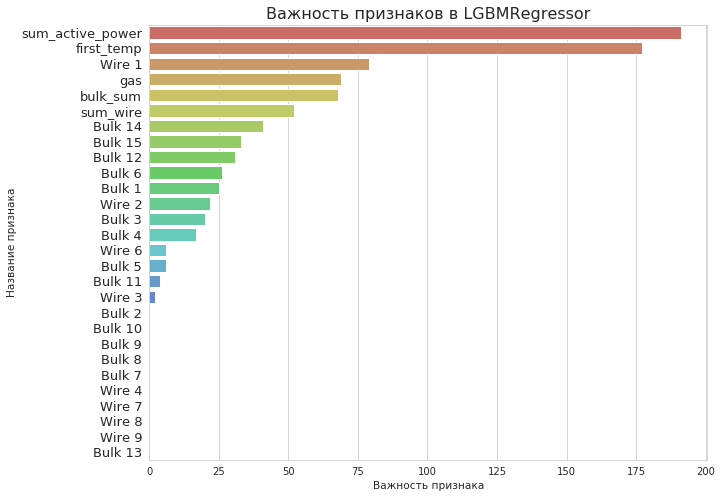

In [75]:
features_importance_plt(model_lgbm.feature_importances_, features_train.columns, 'LGBMRegressor')

<div class="alert alert-block alert-warning">
<b>Комментарий студента ПОСЛЕ РЕВЬЮ 2:</b> и это новое
</div>

In [76]:
lgbm_non_imp_feat = ['Bulk 2', 'Bulk 10', 'Bulk 9', 'Bulk 8', 'Bulk 7',
                     'Wire 4','Wire 7', 'Wire 8', 'Wire 9', 'Bulk 13']
lgbm_features_train = features_train.drop(lgbm_non_imp_feat, axis=1)
lgbm_features_test = features_test.drop(lgbm_non_imp_feat, axis=1)

model_lgbm.fit(lgbm_features_train, target_train)
pred_lgbm = model_lgbm.predict(lgbm_features_train)

results.append({'Модель': 'LGBMRegressor WO NI', 
                'Параметры': lgbm_best_params,  
                'MAE': mae(target_train, pred_lgbm)})

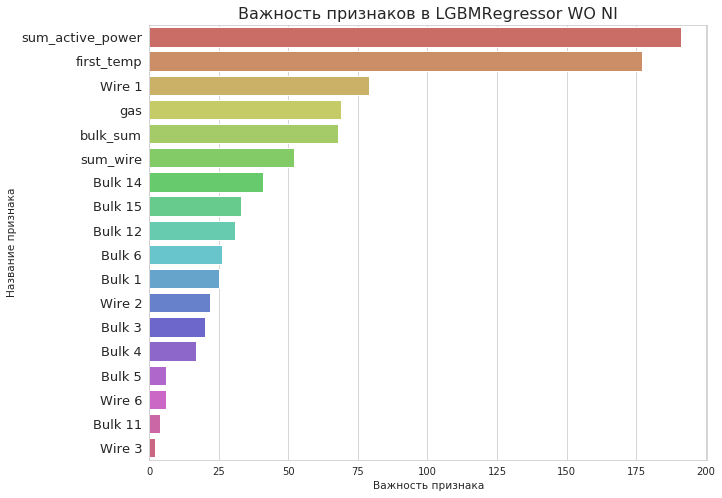

In [77]:
features_importance_plt(model_lgbm.feature_importances_, lgbm_features_train.columns, 'LGBMRegressor WO NI')

Посмотрим на таблицу с результатами.

In [78]:
results_df = pd.DataFrame(results).sort_values('MAE').reset_index(drop=True)
display(results_df.sort_values('MAE'))

,Модель,MAE,Параметры
0,CatBoostRegressor WO NI,4.344000,"{'iterations': 386, 'depth': 3, 'l2_leaf_reg':..."
1,CatBoostRegressor,4.477161,"{'iterations': 386, 'depth': 3, 'l2_leaf_reg':..."
2,LGBMRegressor,5.118398,"{'max_depth': 3, 'n_estimators': 147, 'num_lea..."
3,LGBMRegressor WO NI,5.118398,"{'max_depth': 3, 'n_estimators': 147, 'num_lea..."
4,Lasso,7.549048,NaN
5,LinearRegression,8.714699,NaN


Лучше всего себя показал CatBoostRegressor. Проверим модели на тесте.

Интересно заметить, что после удаления маловажных признаков, MAE CatBoost улучшилась, а по LGBM не изменилась.

## Проверка на тесте

In [79]:
pred_test_lgbm = model_lgbm.predict(lgbm_features_test)
MAE_test_lgbm = mae(target_test, pred_test_lgbm)
print('МАЕ LGBM на тестовой выборке:', MAE_test_lgbm)

МАЕ LGBM на тестовой выборке: 6.411996637205036


In [80]:
pred_test_cbr = model_cbr.predict(cbr_features_test)
MAE_test_cbr = mae(target_test, pred_test_cbr)
print('МАЕ CatBoost на тестовой выборке:', MAE_test_cbr)

МАЕ CatBoost на тестовой выборке: 6.181646187723035


### Вывод

Мы обучили 4 модели:
1. LinearRegression - выделили валидационную выборку, нормализовали данные StandardScaler
2. Lasso - попробовали подобрать гиперпараметры с помощью GridSearchCV, данные нормализовали в StandardScaler.
3. CatBoostRegressor - с помощью gridsearch подобрали лучшие гиперпараметры. Модель показала себя лучше всех. MAE на тесте = 6.1816
4. LGBMRegressor - с помощью GridSearchCV подобрали лучшие гиперпараметры. Обученная модель оказалась на втором месте. MAE на тесте = 6.4119

Также можно обратить внимание, что самые значимые признаки - первый замер температуры и активная мощность. Этот факт объясним, т.к. по сути основной вклад в финальную температуру делают начальной температуре + нагрев(мощность на электродах).

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Привет! Подскажи, пожалуйста, как бы я ещё мог улучшить результат, а то я всю голову и глаза сломал, пока рылся в интернетах.
    Может с признаками что-то ещё придумать можно, или какие-то другие гиперпараметры использовать?
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>
И не зря, Егор - хороший проект вышел - 5 баллов! Метрика - уже классная.<br>
Обработка данных, модельная работа, конечные результаты, анализ важности, мультиколлинеарность, подбор парамптров - многое удалось как надо<br> Очень здорово, что сразу ищешь новые фичи, думаешь над ними, анализируешь. Это тот самый подход, который нужен, чтобы искать ту саму модель для заказчика)<br> 
    
Тут улучшить можно, добавив суммарные значения по каждой присадке. Метрика будет получше.<br>
Попробуешь?<br>По идеее, факторы, обозначенные у тебя ".._count" - можно удалять. Их сложно будте потом точно спрогнозировать. Количество мощности и присадок - ещё туда-сюда, а вот количество итерация - очень случайная вещь, скорее всено.<br>
    
Плюc - перестал с какого-то момента запускаться код - почмотри, пожалуйста.
Спасибо)<br>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ.

<div class="alert alert-block alert-warning">
<b>Комментарий студента ПОСЛЕ РЕВЬЮ:</b> Никак не получилось сделать MAE меньше 6.3. :(
    
Надо либо ещё фичи выдумывать, либо как-то иначе существующие обрабатывать, либо подбирать ещё другие гиперпараметры, либо вообще другую модель брать.
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
ОК, Егор, увидел твои доработки, принято.<br>
Метрика 6.3 - отличный результат. В масштабах производства ( у нас целевая 1500 градусов) разница пол-градуса между моделями - вряд ли существенна)) Да и сравнивать  метрики моделей надо не только по среднему, но и с учётом разброса. Поэтому счита твой результат - однозначно приемлемым. Дальнейшее улучшение уже лежит в области отсечения некоторых строк из модели, гиперпараметры - ты прав.<br>
 
Технически - очень добротная работа. <br>
Всегда стараюсь на этом проекте сказать всем вот ещё что: цель заказчика - экономия энергоресурсов.<br>
И в этом проекте искали как раз способ точно предсказывать температуру. И круто использовали для этого весь арсенал<br>
А если рассудать с позиции такой: а что нужно сделать, чтобы снизить энергопотребление?<br>
Судя по модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Вывод понятен. Теперь надо разработать мероприятия для этого решения. И тут вопрос возникает скм собой: а это так точно? мы можем управлять первой температурой? В общем, наша модель - только начало работы над энергоэффективностью.<br>
    
Так же есть ещё одна идея, которую хотел предложить тебе на обсуждение.<br>
Возможно, покажется интересным<br><br> 

Дело касается принципиально иного подхода к поиску решения для снижения энергопотребления на производстве<br>
Смотри, Создание данной модели (таково было задание) двигалось по пути "угадывания" температуры<br>
Но мы же знаем жизнь)) лёгкие колебания температур (как и нашего настроения, нашего веса.....)<br>
есть всегда. Более того - будут вегда! И нам что, стараться угадывать их?<br>
Не угонимся, "пупок" развяжется))))) <br>
Предложу для подобных проектов подумать вот в какую сторону<br>
    
Итак, разброс в измерениях - есть, был и будет!! (т.к. этому благоприятствует разнообразие факторов самого проиозводства)<br>
    Тогда задачу можно поставить так: <u>надо уменьшить разброс в измерениях</u>. В данном случае в температуре.<br>
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.<br>
А что, если фикировать случаи, когда температура выходит за эти границы?<br>
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству: <br>
а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, <br>
что там было с электродами, ограничения только в фантазиях ну и в знаниях самого производства..... <br>
И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. <br>
Ну и разрабатывать энергосберегательные мероприятия.<br><br>
 
<font color='green'>
В общем-то, готов ОК-уть проект. Или ты будешь ещё пробовать улучшать?

<div class="alert alert-block alert-warning">
<b>Комментарий студента ПОСЛЕ РЕВЬЮ 2:</b> CatBoost упал до 6.18, думаю можно заканчивать.
    Кстати, по поводу решения этой задачи через классификацию я думал, но всё таки задание стояло для метрики MAE
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 3</u></b>
</font>
<font color='green'><br>И это - СУПЕР. Ты молодец, что ещё "поджал" эту метрику!<br>
А любую задачку можно решать разными способами. Тут важно изначально с бизнес-посылом разобраться, а потом и метод решения уже придумывать.<br>
Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)<br>

## Отчёт по проекту

1. Мы загрузили датасеты и провели исследовательский анализ данных. В результате анализа были выявлены:
- пустые значения в добавлении присадков, которые заполнили 0, и в первой/конечной температуре, которые удалили;
- выброс по реактивной мощности, который слишком отбивался от всех значений. Его удалили;
- некорректные типы значений дат, которые привели к нужным типам;
- всего один замер температуры по 741 партии, которые пришлось удалить, т.к. крайне сложно было бы выявить последний замер, который являлся таргетом для моделей;

2. Собрали из предобработанных датасетов один датасет с признаками и таргетом, убрав всё лишнее или сагрегировав имеющиеся данные;

3. Оценили данные на адекватность - сравнили время первого и последнего замера температуры с временем выполнения других действий по партии (добавление присадков, нагрев электродами), в результате чего возникли вопросы к бизнесу - зачем выполнять действия с партией (добавление материалов, нагрев) до первого и после финального замеров температуры? Из итогового датасета удалили партии, по которым выполнялись действия после финального замера температуры, т.к. он является таргетом.

4. Проверили данные на мультиколинеарность. Заметили коллинеарность в активной и реактивной мощностях, в связи с чем удалили один из признаков - реактивную мощность. Также удалили столбец Wire 5, т.к. в нём были только нули.

5. Мы обучили 4 модели:
    1. LinearRegression - выделили валидационную выборку, нормализовали данные в StandardScaler
    2. Lasso - попробовали подобрать гиперпараметры с помощью GridSearchCV, данные нормализовали в StandardScaler.
    3. CatBoostRegressor - с помощью gridsearch подобрали лучшие гиперпараметры. Модель показала себя лучше всех. MAE на тесте = 6.1816
    4. LGBMRegressor - с помощью GridSearchCV подобрали лучшие гиперпараметры. Обученная модель оказалась на втором месте. MAE на тесте = 6.4119

6. Самые значимые признаки для моделей - первый замер температуры и активная мощность. Этот факт объясним, т.к. по сути основной вклад в финальную температуру делают начальной температуре + нагрев(мощность на электродах).

**Итог:**

Мы построили модель CatBoostRegressor, которая предсказывает финальную температуру на основании данных по начальной температуре, нагреву и добавлении присадков. Таким образом, чтобы снизить электропотребление и знать финалную температуру, необходимо контролировать диапазон первоначальной температуры, внимательно следить за химичиеским составом присадков, и выстроить чёткий производственный процесс по времени добавления присадков.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
<u>КОММЕНТАРИЙ ТИМЛИДА</u>
</font>
<font color='green'><br>
Привет Егор!<br>
Поздравляю с приобретением ещщё одной специальности!!!!<br>
    
С отчётом - ОК. Замечу ещё, что изучение бизнес-процессов заказчика - очень важный этап, который может вызывать сложности. Но без этого в нашей работа не обойтись. Можно сказать - вскрывать особенности процессов заказчика - часть нашей работы. Ведь замоделировать можно только то, что понимаешь). Также, хотел бы отметить твою графическую работу. Она хорошо подкрепляла аналитику. На защите заказчику - хорошая графика - может прибавить дополнительной лояльности. Поэтому, стоит её улублять и дальше. <br>
Также отмечу, что тебе удалось быстро вникнуть в суть задачи. А это не проcто - понять новую бизнес-задачу. Здорово, что есть такой важный скил.<br>

Далее скажу, что стараюсь говорить всем на финале.<br>
Пройден большой путь. Со своими коcогорами и равнинами, медианами и дисперсиями)<br>
Умение аналитически мыслить, писать красивый код, эффективно автоматизировать расчёты, видеть задачи бизнеса через призму моделирования - вот то основное, что  останется у тебя важного после нашей школы. А дальше - только взращивать посеянные зёрна и укреплять свои скилы.<br><br>
Если говорить о развитии дополнительных компетенций, рекомендовал бы ещё глянуть такие области знаний:<br>
1) Организация проектов по проведению моделирования (например Методология CRISP-DM (Cross-Industry Standard Process)<br>
2) Умения системно подходить к решению аналитической задачи. (например методология ТРИЗ, системный анализ)<br>
3) Если в промышленности будут проекты, то рекоммендовал бы освоить  "Статистичекий контроль качества (SPC)"<br>
4) Ещё важный навык: перевод результататов моделирования на язык бизнеса. Т.е. понимание, как целевые показатели моделей влияют на финансовую выгоду заказчика.<br>
5) Если говорить о модельных рекоммендациях, то есть ещё такие способы как блендинг и стакинг разных моделей.<br><br>

Спасибо!<br>
И УДАЧИ)